In [422]:
import scipy.io
import scipy.signal
import scipy.fft
import matplotlib.pyplot as plt
import numpy as np

In [423]:
#Loading the audio file
signal = scipy.io.wavfile.read('signal.wav')
numSamples = len(signal[1])
print('Sample rate is:', signal[0], 'and the number of signals is:', numSamples)
print('This corresponds to', numSamples/signal[0], 'seconds')

Sample rate is: 16000 and the number of signals is: 18091
This corresponds to 1.1306875 seconds


In [424]:
#Mean subtraction
mean = np.mean(signal[1])
print(mean)
meanSub = signal[1] - mean

11756.525786302582


In [425]:
#Pre-emphasis
b = 0.97 #given constant
np.insert(meanSub, 0, 0)
preEmp = np.array([meanSub[i]-b*meanSub[i-1] for i in range(1, numSamples-1)])
print(preEmp)


[ 279946.55422641 -120352.58577359  -41547.25577359 ...  102152.87422641
 -137258.38577359 -149305.20577359]


In [426]:
#Computing frames
#Window length 𝐿 set to 25 milliseconds: this is (25/1000)/(1/16000) = 400 samples
#Window shift 𝑆 set to 10 milliseconds: this is (10/1000)/(1/16000) = 160 samples
L = 400
S = 160
#dimensions of the return array are ceil((numSamples-L)/S) rows by L samples
frames = []
k = 0
pad = False
while not pad:
    frames.append([])
    n = 0
    while  n<L:
        ind = k*S+n
        sample = 0
        if  ind<len(preEmp):
            sample = preEmp[ind]
        else:
            pad = True
        frames[k].append(sample)
        n+=1
    k+=1
frames = np.array(frames)
print(frames.shape)

(112, 400)


In [427]:
#Applying window function
window = scipy.signal.hamming(L)
#print(window)
for row in range(len(frames)):
    frames[row]*=window
print(frames.shape)


(112, 400)


In [428]:
#Computing the Fourier transform
N = 512 #number of DFT points, given
fourier = scipy.fft.fft(frames, N)
print(fourier.shape)


(112, 512)


In [429]:
#Computing the magnitude and power spectra
magnitude = np.abs(fourier)
print(magnitude)
power = np.square(magnitude)
print(power.shape)

[[ 2830872.47675556  1117110.26966869   777221.72347282 ...
    661706.29366842   777221.72347282  1117110.26966869]
 [ 1989031.58566385  1588940.89108746  1142095.31815249 ...
   1379208.96099982  1142095.31815249  1588940.89108746]
 [  418363.81492086   250527.79721315   331618.80200223 ...
   1364018.60205705   331618.80200223   250527.79721315]
 ...
 [  713476.74749506  5063369.04896551  7766291.61521661 ...
   8158827.45224225  7766291.61521661  5063369.04896551]
 [ 8399684.50373869  4550619.997942    1231470.51488752 ...
   4204315.65953491  1231470.51488752  4550619.997942  ]
 [15595388.91309609 14038095.94793538 11386588.08049257 ...
  10057161.60033826 11386588.08049257 14038095.94793538]]
(112, 512)


(23, 257)
(112, 23)


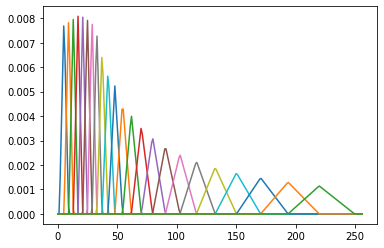

In [430]:
#Mel-filterbank application
mel_filters = np.array(np.load('mel_filters.npy'))
plt.plot(mel_filters.T)
print(mel_filters.shape)
#mel = mel_filters * power[:23, :257]
mel = []
#for row in range(len(mel_filters)):
#    mel.append(np.sum(mel_filters[row]*power[row][:257]))
#mel = np.array(mel)
mel = np.matmul(power[:,:257], np.swapaxes(mel_filters, 0, 1))
print(mel.shape)


In [431]:
#taking the log
mellog = np.maximum(np.full(mel.shape, -50), np.log(mel))
print (mellog.shape)

(112, 23)


In [432]:
#Computing the DCT and “liftering”:
c = []
for i in range(mellog.shape[0]):
    val = [np.sum(np.array(range(mellog.shape[1]))*np.cos((np.array(range(mellog.shape[1]))+0.5)*(np.pi*i/23)))]
    c.append(val)
c = np.array(c)
print(c.shape)
c = c[:13]
#c = c[:13]
print(c)

(112, 1)
[[ 2.53000000e+02]
 [-1.07114343e+02]
 [-3.55271368e-14]
 [-1.18263012e+01]
 [-3.55271368e-14]
 [-4.20110725e+00]
 [-4.61852778e-14]
 [-2.09743431e+00]
 [-7.46069873e-14]
 [-1.22830379e+00]
 [ 2.84217094e-14]
 [-7.84362773e-01]
 [-2.30926389e-14]]


ValueError: operands could not be broadcast together with shapes (13,1) (112,13) 

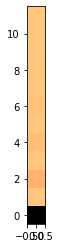

In [433]:
#putting it all together
#cdata = np.swapaxes(c, 0, 1)
#print(cdata)
plt.imshow(c[1:], interpolation='nearest', cmap='copper', origin='lower', aspect='equal')
reference = np.load('reference_mfcc.npy')
diffs = np.absolute(c-reference)
print(diffs)
mse = (np.square(c - reference)).mean()
print(mse)
#plt.imshow(mellog, interpolation = 'nearest', origin='lower')
#plt.imshow(power, interpolation = 'nearest', origin='lower')